In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import colorsys
from math import pi, ceil, floor, cos, sin
import glob
import pandas as pd
import os

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

sys.path.insert(0, './segmentation_methods')

from ipynb.fs.full.general_functions import UNET_VALIDATION, HSV_VALIDATION, NO_VALIDATION
import ipynb.fs.full.methods_names as methods

_root       = "./blood_samples/samples/"
results_dir = "./segmented/"

2.4.1
2.4.0


Errors: 0


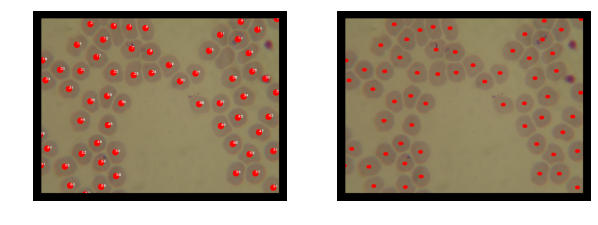

In [5]:
def not_yellow_random_color():
    color = np.random.randint(1,256, size=3)
    hsv = colorsys.rgb_to_hsv(color[0],color[1],color[2])
    if 30 <= hsv[0] <= 90:
        return not_yellow_random_color()
    return tuple((int(color[0]),int(color[1]),int(color[2])))
    

def compare_parasites_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
        
    
    #faz um retangulo ao redor da imagem para remover as marcacoes proximas a borda
    manual = cv2.rectangle(manual, (0,0), (640,480), (0,0,0), 40)
    img    = cv2.rectangle(img, (0,0), (640,480), (0,0,0), 40)
        
    
    manual = manual.copy()
    img = img.copy()
    
    #encontra as marcações relacionadas
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    for i in range(total_count1):
        if stats1[i, cv2.CC_STAT_AREA] > 1000:
            continue
        for y in range(total_count2):
            if stats2[y, cv2.CC_STAT_AREA] > 1000:
                continue
            
            dist = np.linalg.norm(centroids1[i]-centroids2[y])
            if dist < 30:
                color = not_yellow_random_color()
                cX, cY = centroids1[i]
                cv2.circle(img, (int(cX),int(cY)), 10, color, -1)
                cX, cY = centroids2[y]
                cv2.circle(manual, (int(cX),int(cY)), 10, color, -1)
                
                
    #conta quantas marcações amarelas sobraram
    img_mask    = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    manual_mask = cv2.inRange(cv2.cvtColor(manual, cv2.COLOR_RGB2HSV), (30,200,200), (50,255,255))
    errors = 0
    
    total_count1, _, stats1, centroids1 = cv2.connectedComponentsWithStats(img_mask, 4, cv2.CV_32S)
    total_count2, _, stats2, centroids2 = cv2.connectedComponentsWithStats(manual_mask, 4, cv2.CV_32S)
    
    
#     plt.imshow(img_mask)
#     plt.show()
#     plt.imshow(manual_mask)
#     plt.show()
    errors = total_count1 + total_count2 - 2
    
    return errors, img, manual


if __name__ == "__main__":
    #manual = "./blood_samples/ground_truth/blood_smear_1.JPG"
    manual = "./blood_samples/ground_truth/blood_smear_7.JPG"
    manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    #img = "./segmented/hsv/blood_smear_1_otsu.png"
    img = "./segmented/oliveira/blood_smear_7.png"
    img    = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
    errors, img, manual = compare_parasites_markers(manual, img)

    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

{'true_positive': 33, 'true_negative': 0, 'false_positive': 54, 'false_negative': 97, 'cells_qtd': 87, 'ground_truth_qtd': 134}
Errors: 151


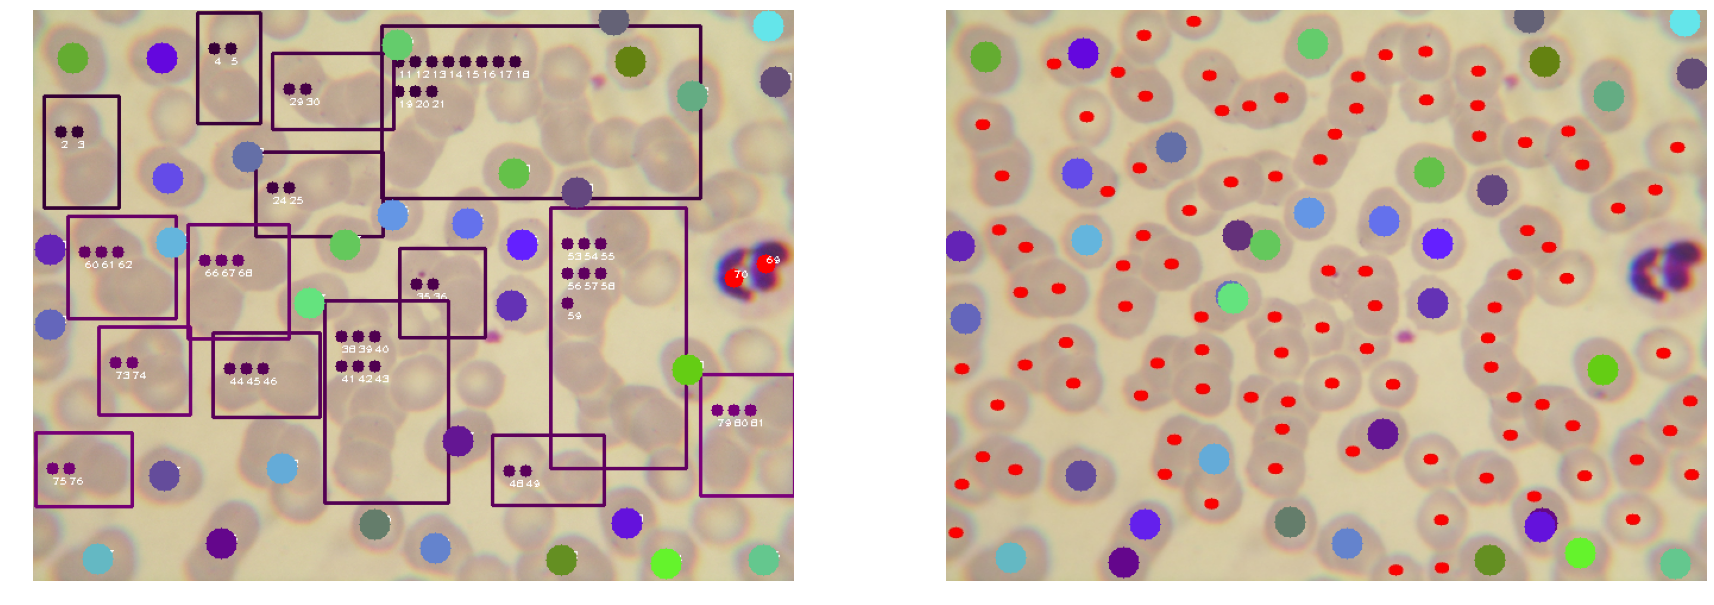

In [6]:


def get_img(name):
    return cv2.imread(name,1)
    
    
def not_red_random_color():
    color = np.random.randint(1,256, size=3)
    color[0] = 100
    if (color[1] < 100 and color[2] < 100):
        return not_red_random_color()
    elif (color[1] > 230 and color[2] > 230):
        return not_red_random_color()
    else:
        return tuple((int(color[0]),int(color[1]),int(color[2])))
    



def compare_markers(manual, img):
    
    if type(manual) == str:
        manual = cv2.cvtColor(cv2.imread(manual,1), cv2.COLOR_BGR2RGB)
        manual = cv2.resize(manual,(640,480))
        
    if type(img) == str:
        img = cv2.cvtColor(cv2.imread(img,1), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(640,480))
        
    manual = manual.copy()
    img = img.copy()
    
    
    true_positive = 0
    true_negative = 0 #nao sera usado
    false_positive = 0
    false_negative = 0
    
    errors = 0
    total = 0
    manual_total = 0
    max_area = 300#despreza as marcações das bordas
    min_area = 100
    
    #procura por todas as marcacoes que estejam em posicoes similares nas duas imagens
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_count, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total += total_count - 1
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_count, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_total += manual_count -1
    
    #print("total", total, "manual_total", manual_total)
    
    
    #das celulas restantes procuro a marcação relacionada
    for m_c in manual_centroids:
        i = 0
        for c in centroids:
            dist = np.linalg.norm(c-m_c)
            if dist < 20 and stats[i, cv2.CC_STAT_AREA] < max_area:
                cX, cY = m_c
                color = not_red_random_color()
                cv2.circle(manual, (int(cX),int(cY)), 13, color, -1)
                cX, cY = c
                cv2.circle(img, (int(cX),int(cY)), 13, color, -1)
                break
            i += 1
        
    
    #conta as células que estao agrupadas
    #relacionando com as posicoes na contagem manual
    
    
    def has_more_groups(img, color):
        mask = cv2.inRange(img, (color,0,color), (255,0,255))
        return np.sum(mask)

    color = 50

    
    while (has_more_groups(img, color)):
        #encontra a caixa        
        mask = cv2.inRange(img, (color+2,0,color+2), (color+2,0,color+2))
        
        #preenche as bordas falhadas do retangulo
        image = img_as_bool(mask)
        out = ndi.distance_transform_edt(~image)
        out = out < 0.05 * out.max()
        out = morphology.skeletonize(out)
        out = morphology.binary_dilation(out) #, morphology.footprints) #morphology.selem.disk(1)
        out = segmentation.clear_border(out)
        out = out | image
        mask[out] = 255
        
        #encontra o retangulo que envolve as celulas
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        max_area = 0
        sel = 0
        for c in range(len(cnts)):
            area = cv2.contourArea(cnts[c])
            if max_area < area:
                max_area = area
                sel = c
        x,y,w,h = cv2.boundingRect(cnts[sel])
        #cv2.rectangle(mask, (x,y), (x+w,y+h), 255, 3)
            
        
        #contagem das celulas encontradas pelo algoritmo
        #conta as celulas da cor da caixa
        mask_cells = cv2.inRange(img, (color,0,color), (color,0,color))
        box_count, _, _, _ = cv2.connectedComponentsWithStats(mask_cells, 4, cv2.CV_32S)
        #conta as celulas vermelhas ainda dentro da caixa
        img_cut = img[y:y+h,x:x+w]
        hsv = cv2.cvtColor(img_cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        
        cell_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                center = centroids[i]
                cell_count += 1
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(img, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        cell_count += box_count-1
        
        true_positive = cell_count
        
        
        #conta as celulas dentro da caixa na contagem manual
        cut = manual[y:y+h,x:x+w]
        hsv = cv2.cvtColor(cut,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
        num, _, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
        max_area = 300
        min_area = 100
        manual_count = 0
        for i in range(num):
            stat = stats[i]
            if (min_area < stat[cv2.CC_STAT_AREA] < max_area):
                manual_count += 1
                center = centroids[i]
                #marca as celulas que foram contadas na imagem original
                cX, cY = center
                cv2.circle(manual, (x+int(cX),y+int(cY)), 13, (0,255,0), -1)
        
        
        mask_cells = mask_cells[y:y+h,x:x+w]
        
        total        += cell_count
        manual_total += manual_count
        #print("count",cell_count, "manual",manual_count)
        
        err = cell_count - manual_count
        if (err > 0):
            false_positive += abs(err)
        else:
            false_negative += abs(err)
        errors += abs(err)
        
        color += 5

        
    #conta quantas marcacoes vermelhas sobraram em ambas
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    total_error, _, _, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    total_error -= 1
    false_positive += total_error
        
    hsv = cv2.cvtColor(manual,cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    mask = cv2.erode(mask,np.ones((5,5)))
    manual_error, _, _, manual_centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    manual_error -= 1
    false_negative += manual_error
    
    errors += total_error + manual_error
    
    true_positive = total - false_positive
    
    return errors, img, manual, {"true_positive":true_positive, 
                                 "true_negative":true_negative,
                                 "false_positive":false_positive, 
                                 "false_negative":false_negative,
                                 "cells_qtd": total,
                                 "ground_truth_qtd": manual_total}


if __name__ == "__main__":
    #87 semar_8
    #95 manual
    #manual = cv2.cvtColor(cv2.imread("./blood_samples/ground_truth/blood_smear_7.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.cvtColor(cv2.imread("./blood_samples/ground_truth/blood_smear_8.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    #img    = cv2.cvtColor(cv2.imread("./segmented/oliveira/blood_smear_7.png",1), cv2.COLOR_BGR2RGB)
    img    = cv2.cvtColor(cv2.imread("./segmented/oliveira/blood_smear_8.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual, st = compare_markers(manual, img)

    
    print(st)
    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(30,30))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

{'true_positive': 86, 'true_negative': 0, 'false_positive': 9, 'false_negative': 33, 'cells_qtd': 95, 'ground_truth_qtd': 134}
Errors: 42


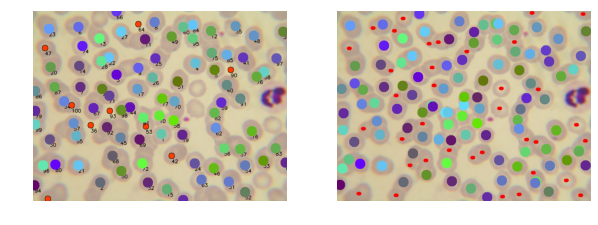

In [7]:
#87 semar_8
#95 manual
if __name__ == "__main__":

    manual = cv2.cvtColor(cv2.imread("./blood_samples/ground_truth/blood_smear_8.JPG",1), cv2.COLOR_BGR2RGB)
    manual = cv2.resize(manual,(640,480))
    img    = cv2.cvtColor(cv2.imread("./segmented/hsv/blood_smear_8_hough.png",1), cv2.COLOR_BGR2RGB)
    errors, img, manual, st = compare_markers(manual, img)

    print(st)
    print("Errors:", errors)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(img)
    ax[1].imshow(manual)
    plt.show()

In [8]:
def getManualCount(name):
    return {"method":"Manual", "path":name, "time":0}


def getOriginalCount(original_result_directory,name):
    image_name = name.replace(_root,original_result_directory+"/").replace(".jpg",".png")
    
    return {"method"  :"Original",
            "time"    : 0,
            "path"    :image_name.replace("../","./")}

def getCellPoseCount(cell_pose_directory,name):
    image_name = name.replace(_root,cell_pose_directory+"/").replace(".jpg",".png")
    return {"method"  :"Cell Pose",
            "time"    : 0,
            "path"    :image_name.replace("../","./")}

def getProjectCount(result_directory,validation,name,method):
    name = name.replace(_root,result_directory+"myresults/"+validation+"/").replace(".jpg","_result.txt")
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        
        data = lines[i].split("\t")
        if len(data) > 1:

            #se for para ler apenas um metodo especifico or ler os resultados de todos os metodos
            #metodos(de segmentacao)
            if method != None and data[0].strip() == method or method == None:
                ret.append({
                    'method'  : data[0].strip(),
                    'time'    : float(data[4].strip().replace("s","")),
                    'path'    : data[5].strip().replace("../","./")
                })
    return ret


def add_to_samples(samples,values):
    for key in values.keys():
        samples[key].append(values[key])
    
    if "validation_type" not in values.keys():
        samples['validation_type'].append(NO_VALIDATION)
    if "cells_error" not in values.keys():
        samples['cells_error'].append(-1)
    if "infection_error" not in values.keys():
        samples['infection_error'].append(-1)
    if ("true_positive" not in values.keys()):
        samples["true_positive"].append(-1)
        samples["true_negative"].append(-1)
        samples["false_positive"].append(-1)
        samples["false_negative"].append(-1)
        samples["cells_qtd"].append(-1)
        samples["ground_truth_qtd"].append(-1)
        samples["acc"].append(-1)
        samples["precision"].append(-1)
        samples["recall"].append(-1)
        samples["f1-score"].append(-1)
    else:
        #(TP+TN)/(TP+TN+FP+FN)
        acc = (values["true_positive"]+values["true_negative"])/(values["true_positive"]+values["true_negative"]+values["false_positive"]+values["false_negative"])
        samples["acc"].append(acc)
        precision = values["true_positive"]/(values["true_positive"]+values["false_positive"])
        samples["precision"].append(precision)
        recall = values["true_positive"]/(values["true_positive"]+values["false_negative"])
        samples["recall"].append(recall)
        f1 = (2*precision*recall)/(precision+recall)
        samples["f1-score"].append(f1)
    
    
    
def read_result_data(results_dir,method=None):
    
    gt_directory = "./blood_samples/ground_truth/"

    samples = {"sample":[],
               "method":[],
               "time":[],
               "path":[],
               "validation_type":[],
               "infection_error":[],
               "cells_error":[],
               "true_positive":[],
               "true_negative":[], #nao usado
               "false_positive":[],
               "false_negative":[],
               "cells_qtd":[],
               "ground_truth_qtd":[],
               "acc":[],
               "precision":[],
               "recall":[],
               "f1-score":[]}

    qtd = 0
    for file in glob.glob(gt_directory+"*.jpg"):
        qtd += 1
        
        #nome da amostra
        file = file.replace("\\","/").lower()
        name = file.replace("ground_truth","samples")
        sample_name = name.replace(gt_directory,"")
        samples['sample'].append(sample_name)

        #adiciona os dados do Ground truth a base
        manual = getManualCount(file)
        add_to_samples(samples,manual)
        
        
        for validation in [NO_VALIDATION]:#, HSV_VALIDATION, UNET_VALIDATION]:
        #for validation in [UNET_VALIDATION]:#, HSV_VALIDATION, UNET_VALIDATION]:
            
            #le os dados obtidos pelo projeto
            data = getProjectCount(results_dir, validation, name,  method)
            for dt in data:
                #adiciona na base
                samples['sample'].append(sample_name)
                print("reading",dt['path'])
                dt['cells_error'], _, _, st = compare_markers(file, dt['path'])
                
                dt['infection_error'], _, _ = compare_parasites_markers(file, dt['path'])
                dt['validation_type']       = validation
                
                dt['cells_qtd']           = st['cells_qtd']
                dt['ground_truth_qtd']    = st['ground_truth_qtd']
                dt["true_positive"]       = st["true_positive"]
                dt["true_negative"]       = st["true_negative"]
                dt["false_positive"]      = st["false_positive"]
                dt["false_negative"]      = st["false_negative"]
            

                add_to_samples(samples,dt)

        
        #le os dados do projeto original
        #orig = getOriginalCount("./segmented/oliveira", name)
        orig = getOriginalCount("./verification-images/malaria-app", name)
        
        samples['sample'].append(sample_name)
        print("reading",orig['path'])
        orig['cells_error'], _, _, st = compare_markers(file, orig['path'])
        orig['infection_error'], _, _ = compare_parasites_markers(file, orig['path'])
        orig['validation_type']       = NO_VALIDATION
        
        orig['cells_qtd']        = st['cells_qtd']
        orig['ground_truth_qtd'] = st['ground_truth_qtd']
        orig["true_positive"]    = st["true_positive"]
        orig["true_negative"]    = st["true_negative"]
        orig["false_positive"]   = st["false_positive"]
        orig["false_negative"]   = st["false_negative"]
        #adiciona na base
        add_to_samples(samples,orig)
        
        #le os resultados do cellpose
        cell_p = getCellPoseCount("./verification-images/cell_pose",name)
        cell_p['cells_error'], _, _, st = compare_markers(file, cell_p['path'])
        cell_p['infection_error'], _, _ = compare_parasites_markers(file, cell_p['path'])
        cell_p['validation_type']       = NO_VALIDATION
        
        cell_p['cells_qtd']        = st['cells_qtd']
        cell_p['ground_truth_qtd'] = st['ground_truth_qtd']
        cell_p["true_positive"]    = st["true_positive"]
        cell_p["true_negative"]    = st["true_negative"]
        cell_p["false_positive"]   = st["false_positive"]
        cell_p["false_negative"]   = st["false_negative"]
        add_to_samples(samples,cell_p)

    try:
        samples = pd.DataFrame(data=samples)
    except:
        for key in samples:
            print (key," len:", len(samples[key]) )
    return samples

if __name__ == "__main__":
    samples = read_result_data(results_dir, method=None)
    print ("end")

reading ./segmented/standalone/blood_smear_1_Yolo 256.png
reading ./segmented/standalone/blood_smear_1_Yolo 384.png
reading ./segmented/standalone/blood_smear_1_Yolo 416.png
reading ./segmented/standalone/blood_smear_1_Yolo 512.png
reading ./segmented/standalone/blood_smear_1_rcnn.png
reading ./segmented/standalone/blood_smear_1_otsu.png
reading ./segmented/standalone/blood_smear_1_otsu_out_blur.png
reading ./segmented/standalone/blood_smear_1_hsv.png
reading ./segmented/standalone/blood_smear_1_hsv_hull.png
reading ./segmented/standalone/blood_smear_1_waterhshed.png
reading ./segmented/standalone/blood_smear_1_hough.png
reading ./segmented/standalone/blood_smear_1_otsu_hough_1_break.png
reading ./segmented/standalone/blood_smear_1_otsu_hough_2_merge.png
reading ./segmented/standalone/blood_smear_1U-net 256.png
reading ./segmented/standalone/blood_smear_1U-net 416.png
reading ./segmented/standalone/blood_smear_1U-net 256b.png
reading ./segmented/standalone/blood_smear_1U-net 416b.png
r

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [6]:
if __name__ == "__main__":
    samples

In [7]:
def print_accs(samples):
    smp = samples.query("method != 'Manual'")
    smp = smp.sort_values('acc',ascending=False)
    print(smp[["validation_type","method","acc","precision","recall","f1-score"]].groupby(["method","validation_type"]).mean().round(3))

if __name__ == "__main__":
    print_accs(samples)




                                               acc  precision  recall  \
method                      validation_type                             
HSV                         standalone       0.432      0.698   0.498   
HSV convex hull             standalone       0.338      0.575   0.421   
Hough Circles               standalone       0.722      0.931   0.758   
OTSU                        standalone       0.416      0.569   0.504   
OTSU + Hough method 1 break standalone       0.787      0.855   0.901   
OTSU + Hough method 2 merge standalone       0.773      0.904   0.834   
OTSU w/out blur             standalone       0.516      0.705   0.585   
Original                    standalone       0.350      0.462   0.441   
RCNN                        standalone       0.791      0.943   0.813   
RCNN v1                     standalone       0.841      0.946   0.883   
RCNN v2                     standalone       0.459      0.459   1.000   
U-net 256                   standalone       0.840 

In [8]:
def print_ltx_accs(samples):
    smp = samples.query("method != 'Manual'")
    smp = smp.sort_values('acc',ascending=False)
    ln = smp[["method","precision","recall","f1-score"]].groupby(["method"]).mean().round(3)
    print(ln.to_latex())

if __name__ == "__main__":
    print_ltx_accs(samples)




\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
method                      &            &         &           \\
\midrule
HSV                         &      0.698 &   0.498 &     0.573 \\
HSV convex hull             &      0.575 &   0.421 &     0.479 \\
Hough Circles               &      0.931 &   0.758 &     0.823 \\
OTSU                        &      0.569 &   0.504 &     0.527 \\
OTSU + Hough method 1 break &      0.855 &   0.901 &     0.875 \\
OTSU + Hough method 2 merge &      0.904 &   0.834 &     0.861 \\
OTSU w/out blur             &      0.705 &   0.585 &     0.629 \\
Original                    &      0.462 &   0.441 &     0.448 \\
RCNN                        &      0.943 &   0.813 &     0.869 \\
RCNN v1                     &      0.946 &   0.883 &     0.914 \\
RCNN v2                     &      0.459 &   1.000 &     0.629 \\
U-net 256                   &      0.963 &   0.867 &     0.909 \\
U-net 256b                  &      0.937 &   0.819 &     0.86

In [9]:
## unetv1 e v6 ficaram bem parecidos
# a yolov2 teve o melhor resultado

In [10]:
if __name__ == "__main__":
    samples

In [11]:
if __name__ == "__main__":
    samples["errors"] = abs(samples["ground_truth_qtd"] - samples["cells_qtd"])
    samples["errors_perc"] = samples["errors"] * 100 / samples["ground_truth_qtd"]


In [12]:
if __name__ == "__main__":
    samples[samples['sample'].str.contains("blood_smear_9")][["method","ground_truth_qtd","cells_qtd","errors","errors_perc"]]

In [13]:
if __name__ == "__main__":
    samples[["method", "errors_perc"]].groupby(["method"]).mean().round(3)

In [14]:
def print_ltx_acertos(samples):
    samples["errors"] = abs(samples["ground_truth_qtd"] - samples["cells_qtd"])
    samples["errors_perc"] = samples["errors"] * 100 / samples["ground_truth_qtd"]
    smp = samples.query("method != 'Manual'")
    smp = smp.sort_values('errors',ascending=False)
    ln = smp[["method", "errors_perc"]].groupby(["method"]).mean().round(3)
    print(ln.to_latex())

if __name__ == "__main__":
    print_ltx_acertos(samples)




\begin{tabular}{lr}
\toprule
{} &  errors\_perc \\
method                      &              \\
\midrule
HSV                         &       34.352 \\
HSV convex hull             &       32.256 \\
Hough Circles               &       23.703 \\
OTSU                        &       23.811 \\
OTSU + Hough method 1 break &        8.846 \\
OTSU + Hough method 2 merge &       18.170 \\
OTSU w/out blur             &       25.834 \\
Original                    &       14.805 \\
RCNN                        &       19.835 \\
RCNN v1                     &        8.197 \\
RCNN v2                     &      121.311 \\
U-net 256                   &       14.269 \\
U-net 256b                  &       17.074 \\
U-net 384                   &       14.119 \\
U-net 384b                  &       16.304 \\
U-net 416                   &       14.792 \\
U-net 416b                  &       15.791 \\
Watershed                   &       15.383 \\
Yolo 256                    &       14.082 \\
Yolo 384            

In [19]:
samples.query("sample == './blood_samples/samples/blood_smear_8.jpg'")

,sample,method,time,path,validation_type,infection_error,cells_error,true_positive,true_negative,false_positive,false_negative,cells_qtd,ground_truth_qtd,acc,precision,recall,f1-score,errors,errors_perc
543,./blood_samples/samples/blood_smear_8.jpg,Manual,0.00000,./blood_samples/ground_truth/blood_smear_8.jpg,standalone,-1,-1,-1,-1,-1,-1,-1,-1,-1.000000,-1.000000,-1.000000,-1.000000,0,-0.000000
544,./blood_samples/samples/blood_smear_8.jpg,Yolo 256,0.25000,./segmented/standalone/blood_smear_8_Yolo 256.png,standalone,0,25,109,0,4,21,113,134,0.813433,0.964602,0.838462,0.897119,21,15.671642
545,./blood_samples/samples/blood_smear_8.jpg,Yolo 384,0.25000,./segmented/standalone/blood_smear_8_Yolo 384.png,standalone,0,16,120,0,10,6,130,134,0.882353,0.923077,0.952381,0.937500,4,2.985075
546,./blood_samples/samples/blood_smear_8.jpg,Yolo 416,0.43000,./segmented/standalone/blood_smear_8_Yolo 416.png,standalone,0,8,127,0,8,0,135,134,0.940741,0.940741,1.000000,0.969466,1,0.746269
547,./blood_samples/samples/blood_smear_8.jpg,Yolo 512,0.26000,./segmented/standalone/blood_smear_8_Yolo 512.png,standalone,0,9,127,0,9,0,136,134,0.933824,0.933824,1.000000,0.965779,2,1.492537
548,./blood_samples/samples/blood_smear_8.jpg,RCNN,17.16000,./segmented/standalone/blood_smear_8_rcnn.png,standalone,0,24,102,0,2,22,104,134,0.809524,0.980769,0.822581,0.894737,30,22.388060
549,./blood_samples/samples/blood_smear_8.jpg,Hough Circles,0.08000,./segmented/standalone/blood_smear_8_hough.png,standalone,0,41,89,0,11,30,100,134,0.684615,0.890000,0.747899,0.812785,34,25.373134
550,./blood_samples/samples/blood_smear_8.jpg,OTSU,0.34000,./segmented/standalone/blood_smear_8_otsu.png,standalone,0,128,37,0,36,92,73,134,0.224242,0.506849,0.286822,0.366337,61,45.522388
551,./blood_samples/samples/blood_smear_8.jpg,OTSU w/out blur,0.36000,./segmented/standalone/blood_smear_8_otsu_out_...,standalone,0,102,47,0,28,74,75,134,0.315436,0.626667,0.388430,0.479592,59,44.029851
552,./blood_samples/samples/blood_smear_8.jpg,HSV,0.38000,./segmented/standalone/blood_smear_8_hsv.png,standalone,0,102,45,0,22,80,67,134,0.306122,0.671642,0.360000,0.468750,67,50.000000


IndexError: index 3 is out of bounds for axis 0 with size 3

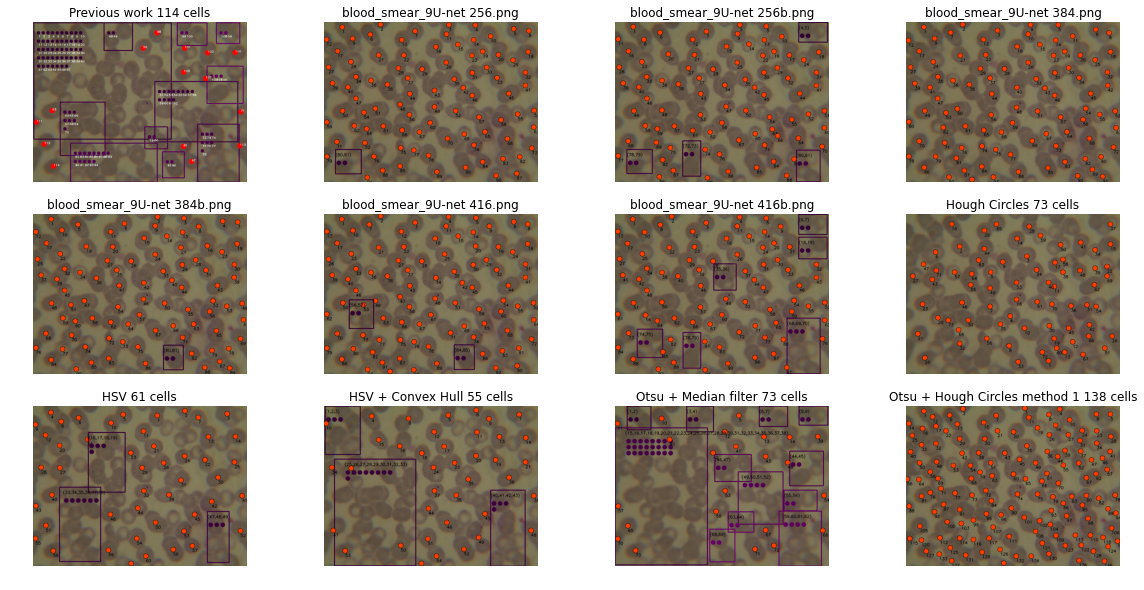

In [15]:
if __name__ == "__main__":
    
    oliv = cv2.imread("./segmented/oliveira/blood_smear_9.png")
    oliv = cv2.cvtColor(oliv, cv2.COLOR_RGB2BGR)


    files = os.listdir("./segmented/standalone/")

    images = [oliv]
    names  = ["Previous work 114 cells"]

    for file in files:
        if file == "blood_smear_9_yolov8.png":
            continue
        if "blood_smear_9" in file:
            img = cv2.imread("./segmented/standalone/%s" % file)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            images.append(img)
            names.append(file)




    names_repl = {"_hough.png":"Hough Circles 73 cells", "_hsv.png":"HSV 61 cells", "_hsv_hull.png":"HSV + Convex Hull 55 cells", "_otsu.png":"Otsu + Median filter 73 cells",
                 "1_break.png":"Otsu + Hough Circles method 1 138 cells", "2_merge.png":"Hough Circles method 2 89 cells", "otsu_out_blur.png":"Otsu 65 cells",
                 "_rcnn.png":"Mask R-CNN 89 cells", "_unet.png":"U-Net 94 cells", "_waterhshed.png":"Watershed 93 cells", "_yolov8-new.png":"Yolov8 79 cells"}

    for key in names_repl:
        for i in range(len(names)):
            name = names[i]
            if name.endswith(key):
                names[i] = names_repl[key]

    #fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(8,20))
    # row = 0
    # col = 0
    # for img, name in zip(images, names):
    #     ax[row][col].set_title(name)
    #     ax[row][col].imshow(img)

    #     col += 1
    #     if col == 2:
    #         row += 1
    #         col = 0
    # plt.show()


    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,10))
    row = 0
    col = 0
    for img, name in zip(images, names):
        ax[row][col].set_title(name)
        ax[row][col].imshow(img)

        col += 1
        if col == 4:
            row += 1
            col = 0
    plt.show()